In [1]:
%%capture --no-display
!pip install jupyterlab_execute_time

In [2]:
import npu

# vector length; must be divisible by 4
vector_size = 2**10

Create Kernel

In [3]:
%%kernel

void vector_add(uint8_t *in1_buffer, uint8_t *in2_buffer, uint8_t *out_buffer, uint32_t nbytes)
{
    for(int i=0; i<nbytes; i++) {
        out_buffer[i] = in1_buffer[i] + in2_buffer[i];
    }
}

Create app builder

In [4]:
from npu.build.kernel import Kernel
from npu.build.appbuilder import AppBuilder
import numpy as np
from npu.build.itkernel import ITWrite

def _simple_behavioural(invobj):
    invobj.out_buffer.array = invobj.in1_buffer.array

class SimpleApplication(AppBuilder):

    def __init__(self, kernel:Kernel):
        self.kernel = kernel
        self.kernel.behavioralfx = _simple_behavioural
        super().__init__()

    def callgraph(self, x_in1: np.ndarray, x_in2: np.ndarray, x_out: np.ndarray) -> None:
        nbytes = x_in1.shape[0]
        result = self.kernel(x_in1, x_in2, nbytes)
        _ = ITWrite(result, bufref=x_out)

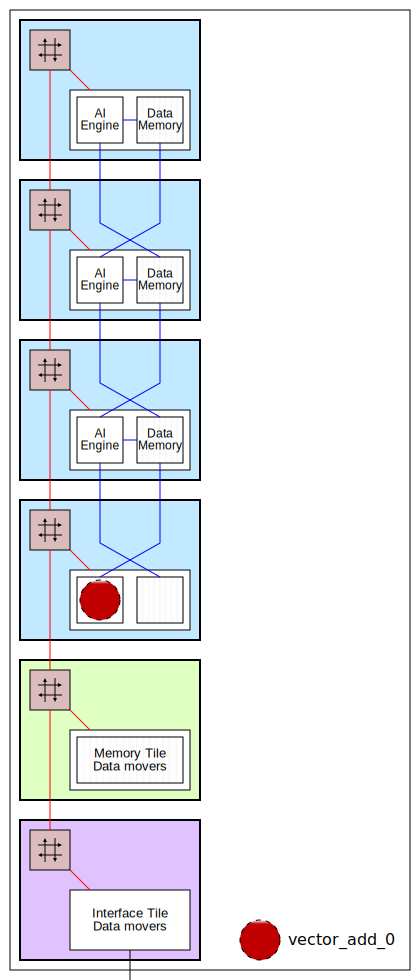

In [5]:
x_in1 = np.zeros(shape=(vector_size), dtype=np.uint8)
x_in2 = np.zeros(shape=(vector_size), dtype=np.uint8)
x_out = np.zeros(shape=(vector_size), dtype=np.uint8)

app_builder = SimpleApplication(kernel=vector_add)
app_builder(x_in1, x_in2, x_out)

app_builder.display()
app_builder.save()

Build the app

In [6]:
app_builder.build(x_in1, x_in2, x_out)

Building the vector_add kernel...
Building the xclbin...
Successfully Building Application... SimpleApplication.xclbin & SimpleApplication.seq delivered


In [7]:
app_builder.metadata

{'application': 'SimpleApplication',
 'kernels': OrderedDict([('itbuffer_0',
               {'name': 'itbuffer_0',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin': {'c_dtype': None,
                  'direction': 'in',
                  'name': 'ITin',
                  'ctype': None,
                  'shape': (1024,),
                  'dtype': 'uint8'},
                 'ITout': {'c_dtype': None,
                  'direction': 'out',
                  'name': 'ITout',
                  'ctype': None,
                  'shape': (1024,),
                  'dtype': 'uint8'}},
                'shape': (1024,),
                'dtype': 'uint8'}),
              ('itbuffer_1',
               {'name': 'itbuffer_1',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin': {'c_dtype

Prep AppRunner and data

In [8]:
from npu.runtime import AppRunner

app = AppRunner('SimpleApplication.xclbin')

# Allocate app input and output buffers to exchange data with NPU
input1_vector = app.allocate(shape=(vector_size))
input2_vector = app.allocate(shape=(vector_size))
output_vector = app.allocate(shape=(vector_size))

# Load data
input1_array = np.zeros(vector_size, dtype=np.uint8)
input2_array = np.zeros(vector_size, dtype=np.uint8)
for i in range(vector_size):
    input1_array[i] = 1
    input2_array[i] = 2

input1_vector[:] = input1_array
input2_vector[:] = input2_array

Run the application

In [9]:
# Pass input_vector buffer to NPU
input1_vector.sync_to_npu()
input2_vector.sync_to_npu()

In [10]:
# Run app on NPU
app.call(input1_vector, input2_vector, output_vector)

In [11]:
# Get results from NPU via output_vector buffer 
output_vector.sync_from_npu()

In [12]:
# Verify output
print(input1_vector)
print(input2_vector)
print(output_vector)

[1 1 1 ... 1 1 1]
[2 2 2 ... 2 2 2]
[3 3 3 ... 3 3 3]


In [14]:
del app

NameError: name 'app' is not defined